## Thank you for visiting my notebook.

[My discussion topic](https://www.kaggle.com/competitions/google-universal-image-embedding/discussion/359351)

## Acknowledgement

This notebook is heavily based on @motono0223's work. Thank you!
https://www.kaggle.com/code/motono0223/guie-clip-tensorflow-train-example

## Key improvements over the original work

- Input 64D vectors to ArcFace (instead of 256D ones) (~ 0.01 gain)
- [Open CLIP ViT-H/14 on LAION-2B](https://laion.ai/blog/large-openclip/) (~ 0.08 gain)
- Reduce LR linearly (~ 0.01 gain)
- Finetune backbone CLIP model for 10 epochs w/ low LR w/o DA (~ 0.02 gain)

## Note

- I suffered from random OOM errors in submission (with CLIP H/14). I gave up more complex architecture because of this.
- You may not be able to reproduce the same result because the random seed is not fixed.

## Model

Almost the same as @motono0223's original work, except that the Dense layer's dim is 64.

- for training:  
backbone(CLIP) + Dropout + Dense(units=64) + Arcface + Softmax (classes=17691)
- for inference:  
backbone(CLIP) + Dropout + Dense(units=64) + L2Norm

## Dataset for training:

Eventually, I used the same datasets as the original work.
I couldn't find any other dataset which works well.

# Libraries

In [1]:
import os
def is_colab_env():
    is_colab = False
    for k in os.environ.keys():
        if "COLAB" in k:
            is_colab = True
            break
    return is_colab

# if google colab, install transformers and tensorflow_addons
# (Note: please use google colab(TPU) when model is trained. 
#  On the kaggle TPU env, the module transformers.TFCLIPVisionModel couldn't be installed.)
if is_colab_env():
    !pip install transformers
    !pip install tensorflow_addons
else: # Kaggle Notebook env
    # for TPU
    # https://www.kaggle.com/code/motono0223/guie-clip-tensorflow-train-example/comments#1916619
    !pip install transformers==4.20.1 -U -q

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 1.12.1 requires huggingface-hub<0.1.0,>=0.0.14, but you have huggingface-hub 0.11.0 which is incompatible.
allennlp 2.7.0 requires transformers<4.10,>=4.1, but you have transformers 4.20.1 which is incompatible.


In [2]:
from transformers import CLIPProcessor, TFCLIPVisionModel, CLIPFeatureExtractor

import re
import os
import glob
import numpy as np
import pandas as pd
import random
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn import metrics
from sklearn.model_selection import KFold, train_test_split, StratifiedKFold
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
import pickle
import json
import tensorflow_hub as tfhub
from datetime import datetime
import gc
import requests
from mpl_toolkits import axes_grid1

2022-11-26 04:45:45.852750: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-26 04:45:45.852887: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-26 04:45:53.582782: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-11-26 04:45:53.585872: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2022-11-26 04:45:53.585914: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-26 04:45:53.585943: I tensorflow/stream_executor/cuda/cud

# Device

In [3]:
import tensorflow as tf
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

AUTO = tf.data.experimental.AUTOTUNE
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2022-11-26 04:45:54.134469: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-11-26 04:45:54.134550: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-11-26 04:45:54.162888: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2022-11-26 04:45:54.162948: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30019}
2022-11-26 04:45:54.163558: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30019


REPLICAS:  8


In [4]:
# If GPU instance, it makes mixed precision enable.
if strategy.num_replicas_in_sync == 1:
    from tensorflow.keras.mixed_precision import experimental as mixed_precision
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_policy(policy) 

In [5]:
class config:
    SEED = 42

    # pretrained model - transfer learning
    RESUME = True
    RESUME_EPOCH = 0
    RESUME_WEIGHT = '../input/guie-clip-tf-train-models/model.H14-e100.h5'

    # backbone model
    MODEL_NAME = "CLIP-ViT-H-14-laion2B-s32B-b79K"
    PRETRAINED_CLIP = f"laion/{MODEL_NAME}"
    PRETRAINED_CLIP_FROM_PT = True
    FREEZE_CLIP = False
    IMAGE_SIZE = 224

    # projection layer
    N_CLASSES = 17691
    EMB_DIM = 64
    DROPOUT_RATE = 0.1
    
    # training
    TRAIN = True
    SHUFFLE = True
    # for first-round (RESUME = False, FREEZE_CLIP = True)
    #AUGMENT = True
    #BATCH_SIZE = 200 * strategy.num_replicas_in_sync
    #EPOCHS = 100
    #MAX_LR_PER_EXAMPLE = 5e-6
    # /first-round
    # for second-round (RESUME = True, FREEZE_CLIP = False)
    AUGMENT = True
    BATCH_SIZE = 25 * strategy.num_replicas_in_sync
    EPOCHS = 10
    MAX_LR_PER_EXAMPLE = 1e-8
    # /second-round
    MIN_LR_PER_EXAMPLE = 1e-9
    save_dir = "."

    DEBUG = False

    ROOT_DIRS = [
        "guie-glr2021mini-tfrecords-label-10691-17690",
        "guie-imagenet1k-mini1-tfrecords-label-0-999",
        "guie-products10k-tfrecords-label-1000-10690",
        #"guie-objectnet-224pix-tfrecords-label-0-312",
        #"guie-omnibenchmark-tfrecord",
    ]

# Function to seed everything
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)

In [6]:
print(config.BATCH_SIZE)

200


# TFRecords

In [7]:
if is_colab_env(): # for google colab env.
    kaggle_backet_dict = {
        "guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://kds-2d8595950771cb234df96ce51a63f9dcd7f6875446c216eb5ea81398",
        "guie-products10k-tfrecords-label-1000-10690" : "gs://kds-bd5de1fcfc5636b47d6ed48a48794b70336cf42bd2a276c4fbcd2619",
        "guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-31d5ada0f474669112699c448cb8759741c402ec75aedfe1fea6fdd6",
        "guie-omnibenchmark-tfrecord" : "gs://kds-b1f7fae3c9a8d7468f3f170254ed8d760bd3d60d6511c42e8ec42636",
        "guie-objectnet-224pix-tfrecords-label-0-312" : "gs://kds-c1e9aafcf6753fbabd519ff9f40252645aa92604c1a5a8ee89264fbe",
    }
else: # for kaggle notebook
    from kaggle_datasets import KaggleDatasets

In [8]:
train_shard_suffix = '*.tfrec'

train_set_path = []
valid_set_path = []
for ROOT_DIR in config.ROOT_DIRS:
    if is_colab_env():
        GCS_DS_PATH = kaggle_backet_dict[ ROOT_DIR ]
    else:
        GCS_DS_PATH = KaggleDatasets().get_gcs_path( ROOT_DIR )
        
    print( f"\"{ROOT_DIR}\" : \"{GCS_DS_PATH}\"," )
    files = sorted(tf.io.gfile.glob(GCS_DS_PATH + f'/{train_shard_suffix}'))
    assert len(files) > 0
    # split data
    train_set_path += random.sample(files, int( len(files) * 0.9 ) )
    valid_set_path += [ file for file in files  if not file in train_set_path ]
    print(ROOT_DIR, ", number of tfrecords = ", len(files))

train_set_path = sorted( train_set_path, reverse=True )
valid_set_path = sorted( valid_set_path )

print("# of tfrecords for training   : ", len(train_set_path))
print("# of tfrecords for validation : ", len(valid_set_path))

if config.DEBUG:
    train_set_path = random.sample( train_set_path, 4)
    print("debug: reduce training data. num=", len(train_set_path))
    print("Train set paths: ", train_set_path)
    
    valid_set_path = train_set_path #valid_set_path[:1]
    print("debug: reduce validation data. num=", len(valid_set_path))
    print("Valid set paths: ", valid_set_path)

"guie-glr2021mini-tfrecords-label-10691-17690" : "gs://kds-c49efdee26188bead0c5765e3dc04bdf71ed4c3dc43b7a73b14ba671",
guie-glr2021mini-tfrecords-label-10691-17690 , number of tfrecords =  32


2022-11-26 04:46:01.389204: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


"guie-imagenet1k-mini1-tfrecords-label-0-999" : "gs://kds-9637d4e1876c2ea1368ea21ea448cf73d10e680c303595d46cec9c44",
guie-imagenet1k-mini1-tfrecords-label-0-999 , number of tfrecords =  50


2022-11-26 04:46:01.831228: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


"guie-products10k-tfrecords-label-1000-10690" : "gs://kds-ac253277c9d645633e9a209d4643981e2db8fd71908bdf762e598ab3",
guie-products10k-tfrecords-label-1000-10690 , number of tfrecords =  20
# of tfrecords for training   :  91
# of tfrecords for validation :  11


2022-11-26 04:46:02.391028: I tensorflow/core/platform/cloud/google_auth_provider.cc:180] Attempting an empty bearer token since no token was retrieved from files, and GCE metadata check was skipped.


In [9]:
def get_num_of_image(file):
    return int(file.split("/")[-1].split(".")[0].split("-")[-1])

train_set_len = sum( [ get_num_of_image(file) for file in train_set_path ] )
valid_set_len = sum( [ get_num_of_image(file) for file in valid_set_path ] )

train_set_len, valid_set_len

(478184, 62829)

# Dataset pipeline

In [10]:
def deserialization_fn(serialized_example):
    parsed_example = tf.io.parse_single_example(
        serialized_example,
        features={
            'image/encoded': tf.io.FixedLenFeature([], tf.string),
            'image/class/label': tf.io.FixedLenFeature([], tf.int64),
        }
    )
    image = tf.image.decode_jpeg(parsed_example['image/encoded'], channels=3)
    image = tf.image.resize(image, size=(config.IMAGE_SIZE, config.IMAGE_SIZE))
    label = tf.cast(parsed_example['image/class/label'], tf.int64)
    image = tf.cast(image, tf.float32) / 255.0
    return image, label

In [11]:
def arcface_format(image, label_group):
    print (image, label_group)
    return {'inp1': image, 'inp2': label_group}, label_group

def rescale_image(image, label_group):
    image = tf.cast(image, tf.float32) * 255.0
    return image, label_group

# Data augmentation function
def data_augment(image, label_group):
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return image, label_group

# Dataset to obtain backbone's inference
# output : ( image, label ), (label) 
def get_backbone_inference_dataset(tfrecord_paths, cache=False, repeat=False, shuffle=False, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices(tfrecord_paths)
    data_len = sum( [ get_num_of_image(file) for file in tfrecord_paths ] )
    if shuffle:
        dataset = dataset.shuffle(len(tfrecord_paths))
    dataset = dataset.flat_map(tf.data.TFRecordDataset)
    dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO) # image[0-1], label[0-999]
    print(dataset)
    if shuffle:
        dataset = dataset.shuffle(data_len//10)

    if augment:
        dataset = dataset.map(data_augment, num_parallel_calls=AUTO)  # (image, label_group) --> (image, label_group)
    dataset = dataset.map(rescale_image, num_parallel_calls = AUTO)  # image[0-1], label[0-n_classes] --> image[0-255], label[0-n_classes]
    dataset = dataset.map(arcface_format, num_parallel_calls=AUTO)   # (image, label_group) --> ({"inp1":image, "inp2":label_group}, label_group )
    if repeat:
        dataset = dataset.repeat()
    dataset = dataset.batch(config.BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

In [12]:
# dataset = tf.data.Dataset.from_tensor_slices(train_set_path[1:2])
# dataset = dataset.map(deserialization_fn, num_parallel_calls=AUTO)
# # print(dataset.unbatch().batch(num_cols * num_rows))
# x, y = next(iter(dataset))
# print("here: " ,x['inp2'])
# print(y)

# Viz tfrecord images

<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(), dtype=int64)
(15, 224, 224, 3)
tf.Tensor(
[12621 11386 15142 15430  4842 14427 16563   585 16002 16537 16334 11191
 16131  7523 11488], shape=(15,), dtype=int64)


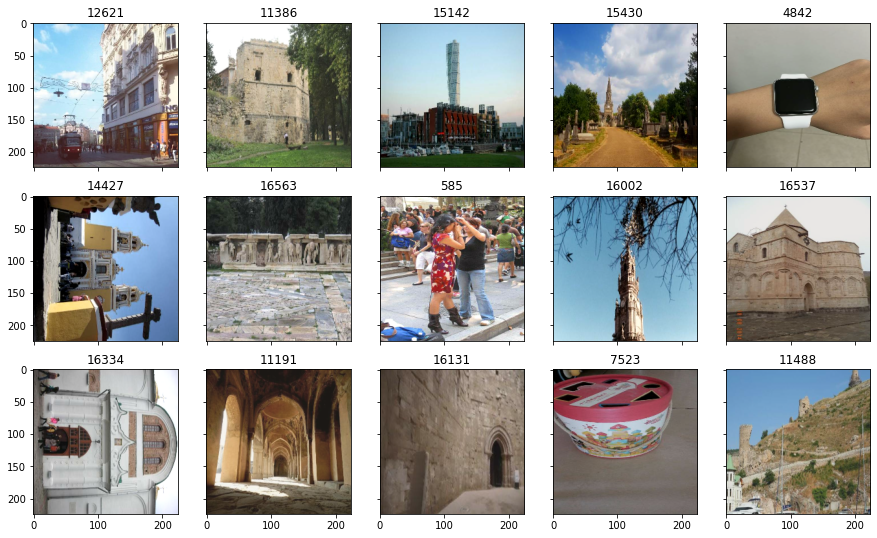

In [13]:

backbone_infer_dataset_encode = get_backbone_inference_dataset(train_set_path, shuffle=True, augment=config.AUGMENT)

num_cols = 3
num_rows = 5
backbone_infer_dataset_encode = backbone_infer_dataset_encode.unbatch().batch(num_cols * num_rows)
x, y = next(iter(backbone_infer_dataset_encode))
print(x["inp1"].shape)
print(x["inp2"])

fig = plt.figure(figsize=(15, 15))
grid = axes_grid1.ImageGrid(fig, 111, nrows_ncols=(num_cols, num_rows), axes_pad=0.4)
print (grid)
for i, ax in enumerate(grid):
    ax.set_title(tf.keras.backend.get_value(x["inp2"][i]))
    ax.imshow(x["inp1"][i]/255)
#     print(tf.keras.backend.get_value(x["inp2"][i]))
    #ax.axis("off")

#del backbone_infer_dataset_encode

# Model

In [14]:
# Arcmarginproduct class keras layer
class ArcMarginProduct(tf.keras.layers.Layer):
    '''
    Implements large margin arc distance.

    Reference:
        https://arxiv.org/pdf/1801.07698.pdf
        https://github.com/lyakaap/Landmark2019-1st-and-3rd-Place-Solution/
            blob/master/src/modeling/metric_learning.py
    '''
    def __init__(self, n_classes, s=30, m=0.50, easy_margin=False,
                 ls_eps=0.0, **kwargs):

        super(ArcMarginProduct, self).__init__(**kwargs)

        self.n_classes = n_classes
        self.s = s
        self.m = m
        self.ls_eps = ls_eps
        self.easy_margin = easy_margin
        self.cos_m = tf.math.cos(m)
        self.sin_m = tf.math.sin(m)
        self.th = tf.math.cos(math.pi - m)
        self.mm = tf.math.sin(math.pi - m) * m

    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'n_classes': self.n_classes,
            's': self.s,
            'm': self.m,
            'ls_eps': self.ls_eps,
            'easy_margin': self.easy_margin,
        })
        return config

    def build(self, input_shape):
        super(ArcMarginProduct, self).build(input_shape[0])

        self.W = self.add_weight(
            name='W',
            shape=(int(input_shape[0][-1]), self.n_classes),
            initializer='glorot_uniform',
            dtype='float32',
            trainable=True,
            regularizer=None)

    def call(self, inputs):
        X, y = inputs
        y = tf.cast(y, dtype=tf.int32)
        cosine = tf.matmul(
            tf.math.l2_normalize(X, axis=1),
            tf.math.l2_normalize(self.W, axis=0)
        )
        sine = tf.math.sqrt(1.0 - tf.math.pow(cosine, 2))
        phi = cosine * self.cos_m - sine * self.sin_m
        if self.easy_margin:
            phi = tf.where(cosine > 0, phi, cosine)
        else:
            phi = tf.where(cosine > self.th, phi, cosine - self.mm)
        one_hot = tf.cast(
            tf.one_hot(y, depth=self.n_classes),
            dtype=cosine.dtype
        )
        if self.ls_eps > 0:
            one_hot = (1 - self.ls_eps) * one_hot + self.ls_eps / self.n_classes

        output = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        output *= self.s
        return output

In [15]:
def get_scale_layer(rescale_mode = "tf"):
    # For keras_cv_attention_models module:
    # ref: https://github.com/leondgarse/keras_cv_attention_models/blob/main/keras_cv_attention_models/imagenet/data.py
    # ref function : init_mean_std_by_rescale_mode()

    # For effV2 (21k classes) : https://github.com/leondgarse/keras_efficientnet_v2

    if isinstance(rescale_mode, (list, tuple)):  # Specific mean and std
        mean, std = rescale_mode
    elif rescale_mode == "torch":
        mean = np.array([0.485, 0.456, 0.406]) * 255.0
        std = np.array([0.229, 0.224, 0.225]) * 255.0
    elif rescale_mode == "tf":  # [0, 255] -> [-1, 1]
        mean, std = 127.5, 127.5
    elif rescale_mode == "tf128":  # [0, 255] -> [-1, 1]
        mean, std = 128.0, 128.0
    elif rescale_mode == "raw01":
        mean, std = 0, 255.0  # [0, 255] -> [0, 1]
    else:
        mean, std = 0, 1  # raw inputs [0, 255]        
    scaling_layer = keras.layers.Lambda(lambda x: ( tf.cast(x, tf.float32) - mean) / std )
    
    return scaling_layer


def get_clip_model():
    inp = tf.keras.layers.Input(shape = [3, 224, 224]) # [B, C, H, W]
    backbone = TFCLIPVisionModel.from_pretrained(config.PRETRAINED_CLIP,
                                                 from_pt=config.PRETRAINED_CLIP_FROM_PT)
    output = backbone({'pixel_values':inp}).pooler_output
    return tf.keras.Model(inputs=[inp], outputs=[output])

def get_embedding_model():
    #------------------
    # Definition of placeholders
    inp = tf.keras.layers.Input(shape = [None, None, 3], name = 'inp1')
    label = tf.keras.layers.Input(shape = (), name = 'inp2')

    # Definition of layers
    layer_resize = tf.keras.layers.Lambda(lambda x: tf.image.resize(x, [config.IMAGE_SIZE, config.IMAGE_SIZE]), name='resize')
    layer_scaling = get_scale_layer(rescale_mode = "torch")
    layer_permute = tf.keras.layers.Permute((3,1,2))
    layer_backbone = get_clip_model()
    layer_dropout = tf.keras.layers.Dropout(config.DROPOUT_RATE)
    layer_dense_before_arcface = tf.keras.layers.Dense(config.EMB_DIM)
    layer_margin = ArcMarginProduct(
        n_classes = config.N_CLASSES, 
        s = 30, 
        m = 0.3, 
        name=f'head/arcface', 
        dtype='float32'
        )
    layer_softmax = tf.keras.layers.Softmax(dtype='float32')
    layer_l2 = tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=-1), name='embedding_norm')

    #------------------
    # Definition of entire model
    image = layer_scaling(inp)
    image = layer_resize(image)
    image = layer_permute(image)
    backbone_output = layer_backbone(image) # model_2
    embed = layer_dropout(backbone_output)
    embed = layer_dense_before_arcface(embed)
    x = layer_margin([embed, label])
    output = layer_softmax(x)
    model = tf.keras.models.Model(inputs = [inp, label], outputs = [output]) # whole architecture

    if config.FREEZE_CLIP:
        assert model.layers[4].layers[1].layers[0].name == 'clip'
        model.layers[4].trainable = False

    opt = tf.keras.optimizers.Adam()
    model.compile(
        optimizer = opt,
        loss = [tf.keras.losses.SparseCategoricalCrossentropy()],
        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(),tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)]
        )

    #------------------
    # Definition of embedding model (for submission)
    embed_model = keras.Sequential([
        keras.layers.InputLayer(input_shape=(None, None, 3), dtype='uint8'),
        layer_scaling,
        layer_resize,
        layer_permute,
        layer_backbone,
        layer_dropout,
        layer_dense_before_arcface,
        layer_l2,
    ])

    return model, embed_model

In [16]:
with strategy.scope():
    model, emb_model = get_embedding_model()

if config.RESUME:
    print(f"load {config.RESUME_WEIGHT}")
    model.load_weights( config.RESUME_WEIGHT )

Downloading:   0%|          | 0.00/4.50k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/3.67G [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFCLIPVisionModel: ['text_model.encoder.layers.14.layer_norm1.weight', 'text_model.encoder.layers.9.mlp.fc1.bias', 'text_model.encoder.layers.9.self_attn.v_proj.weight', 'text_model.encoder.layers.7.mlp.fc1.bias', 'text_projection.weight', 'text_model.encoder.layers.16.mlp.fc2.bias', 'text_model.encoder.layers.22.mlp.fc2.bias', 'text_model.encoder.layers.6.layer_norm1.bias', 'text_model.encoder.layers.4.layer_norm2.bias', 'text_model.embeddings.token_embedding.weight', 'text_model.encoder.layers.22.self_attn.out_proj.bias', 'text_model.encoder.layers.21.layer_norm1.bias', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.10.self_attn.v_proj.bias', 'text_model.encoder.layers.15.self_attn.q_proj.weight', 'text_model.encoder.layers.20.self_attn.v_proj.weight', 'text_model.encoder.layers.20.self_attn.k_proj.bias', 'text_model.encoder.layers.15.mlp.fc2.bias', 'text_model.encoder.layers.4.

load ../input/guie-clip-tf-train-models/model.H14-e100.h5


In [17]:
model.summary()
model.get_layer(index = 4)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, None, None,  0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, None, None, 3 0           inp1[0][0]                       
__________________________________________________________________________________________________
resize (Lambda)                 (None, 224, 224, 3)  0           lambda[0][0]                     
__________________________________________________________________________________________________
permute (Permute)               (None, 3, 224, 224)  0           resize[0][0]                     
____________________________________________________________________________________________

In [18]:
emb_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, None, 3)     0         
_________________________________________________________________
resize (Lambda)              (None, 224, 224, 3)       0         
_________________________________________________________________
permute (Permute)            (None, 3, 224, 224)       0         
_________________________________________________________________
model (Functional)           (None, 1280)              630766080 
_________________________________________________________________
dropout_32 (Dropout)         (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                81984     
_________________________________________________________________
embedding_norm (Lambda)      (None, 64)                0

# Scheduler

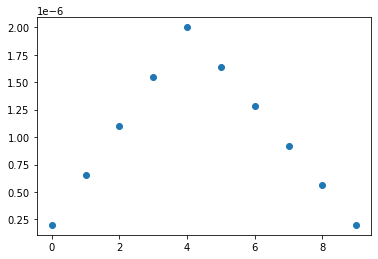

In [19]:
def get_lr_callback(plot=False):
    lr_start   = config.MIN_LR_PER_EXAMPLE * config.BATCH_SIZE
    lr_max     = config.MAX_LR_PER_EXAMPLE * config.BATCH_SIZE
    lr_min     = config.MIN_LR_PER_EXAMPLE * config.BATCH_SIZE
    lr_ramp_ep =4
    lr_sus_ep  = 0
    lr_decay   = 0.95
   
    def lrfn(epoch):
        if config.RESUME:
            epoch = epoch + config.RESUME_EPOCH
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * (config.EPOCHS - epoch - 1) / (config.EPOCHS - lr_ramp_ep - lr_sus_ep - 1) + lr_min
            #lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr
        
    if plot:
        epochs = list(range(config.EPOCHS))
        learning_rates = [lrfn(x) for x in epochs]
        plt.scatter(epochs,learning_rates)
        plt.show()

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

get_lr_callback(plot=True)

# Train entire model 

In [20]:
if config.TRAIN:
    sv_loss = tf.keras.callbacks.ModelCheckpoint(
        config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5", monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True,
        save_weights_only=True, mode='max', save_freq='epoch')

    steps_per_epoch = train_set_len // config.BATCH_SIZE  // 10     # "//10" means that the lr is update every 0.1 epoch.
    validation_steps = valid_set_len // config.BATCH_SIZE
    if valid_set_len % config.BATCH_SIZE != 0:
        validation_steps += 1
    print(steps_per_epoch, validation_steps)
    ds_train = get_backbone_inference_dataset(train_set_path, shuffle=config.SHUFFLE, augment=config.AUGMENT, repeat=False)
    ds_valid = get_backbone_inference_dataset(valid_set_path, shuffle=False, augment=False, repeat=False)

    history = model.fit(
        ds_train,
        epochs=config.EPOCHS,
        callbacks=[get_lr_callback(), sv_loss],
        steps_per_epoch=steps_per_epoch,
        validation_data = ds_valid,
        validation_steps = validation_steps,
        verbose=1
    )

    # load best weight
    model.load_weights(config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_loss.h5")

239 315
<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(), dtype=int64)
<ParallelMapDataset shapes: ((224, 224, 3), ()), types: (tf.float32, tf.int64)>
Tensor("args_0:0", shape=(224, 224, 3), dtype=float32) Tensor("args_1:0", shape=(), dtype=int64)
Epoch 1/10
239/239 [==============================] - 752s 2s/step - loss: 4.6038 - sparse_categorical_accuracy: 0.2773 - sparse_top_k_categorical_accuracy: 0.5060 - val_loss: 3.7972 - val_sparse_categorical_accuracy: 0.3659 - val_sparse_top_k_categorical_accuracy: 0.5858

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.36590, saving model to ./CLIP-ViT-H-14-laion2B-s32B-b79K_224pix-emb64_loss.h5
Epoch 2/10
239/239 [==============================] - 448s 2s/step - loss: 4.3691 - sparse_categorical_accuracy: 0.2998 - sparse_top_k_categorical_accuracy: 0.5302 - val_loss: 3.7014 - val_sparse_categorical_accuracy:

In [21]:
# save for debug
emb_model.save_weights( config.save_dir+f"/{config.MODEL_NAME}_{config.IMAGE_SIZE}pix-emb{config.EMB_DIM}_emb_model.h5" )

In [22]:
history.history.keys()

dict_keys(['loss', 'sparse_categorical_accuracy', 'sparse_top_k_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy', 'val_sparse_top_k_categorical_accuracy', 'lr'])

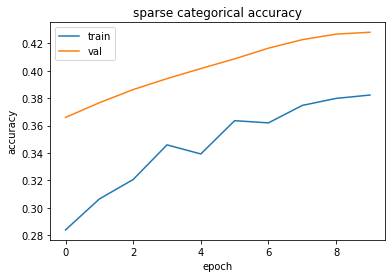

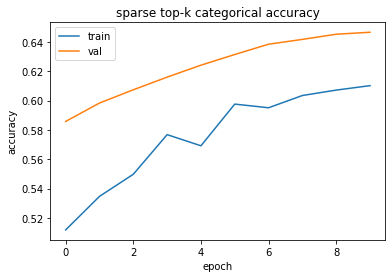

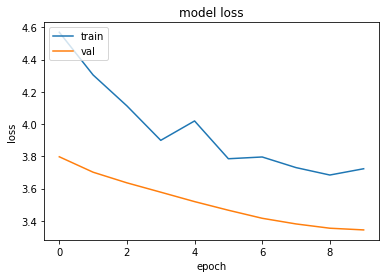

In [23]:
    plt.plot(history.history['sparse_categorical_accuracy'])
    plt.plot(history.history['val_sparse_categorical_accuracy'])
    plt.title('sparse categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['sparse_top_k_categorical_accuracy'])
    plt.plot(history.history['val_sparse_top_k_categorical_accuracy'])
    plt.title('sparse top-k categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

# Create submission.zip

In [24]:
save_locally = tf.saved_model.SaveOptions(
    experimental_io_device='/job:localhost'
)
emb_model.save('./embedding_norm_model', options=save_locally)

from zipfile import ZipFile

with ZipFile('submission.zip','w') as zip:           
    zip.write(
        './embedding_norm_model/saved_model.pb', 
        arcname='saved_model.pb'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.data-00000-of-00001', 
        arcname='variables/variables.data-00000-of-00001'
    ) 
    zip.write(
        './embedding_norm_model/variables/variables.index', 
        arcname='variables/variables.index'
    )

2022-11-26 06:14:22.642011: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
